# Import packages and common functions

In [1]:
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import pandas as pd
import matplotlib.colors
from scipy.stats import spearmanr, pearsonr
from word2number import w2n

def make_aesthetic(hex_color_list=None, with_gridlines=False, bold_title=False, save_transparent=True, font_scale=2):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not:
    # plt.title(r$'\bf{bolded title}$\nAnd a non-bold subtitle')
    
    sns.set(style='white', context='paper', font_scale=font_scale)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#D41876", # Telemagenta
        "#00A896", # Persian green,
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    try:
        plt.rcParams['font.family'] = 'Arial'
    except:
        pass
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    if bold_title:
        plt.rcParams['axes.titleweight'] = 'bold'
    else:
        plt.rcParams['axes.titleweight'] = 'regular'
    plt.rcParams['axes.grid'] = with_gridlines
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = save_transparent
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.titlepad'] = 20*(font_scale/1)
    return hex_color_list

def bootstrap_cor(x, y, method='spearman', iters=10000, alpha=0.95, random_seed=416, round=2):
    """
    Simple function to bootstrap CIs for correlations using Scipy

    Params:
     - x (list or array)
     - y (list or array)
     - method (default='spearman'): Options are ['spearman', 'pearson', 'pointbiserial', 'kendall']
     - iters (int): number of bootstrap iterations
     - alpha (float): confidence level for CI
     - random_seed (int): seed for reproducibility
     - round (int): decimal places to round the output to avoid manual rounding errors 
    """
    np.random.seed(random_seed)
    
    n = len(x)
    correlation_estimates = []

    # Define correlation functions
    if method == 'spearman':
        correlation_func = spearmanr
    elif method == 'pearson':
        correlation_func = pearsonr
    elif method == 'pointbiserial':
        correlation_func = pointbiserialr
    elif method == 'kendall':
        correlation_func = kendalltau
    else:
        raise ValueError("Method should be 'spearman', 'pearson', 'pointbiserial', or 'kendall'")

    # Get observed correlation
    observed, _ = correlation_func(x, y)

    # Ensure there's enough variability
    if np.std(x) == 0 or np.std(y) == 0:
        raise ValueError("Error: no variability in either x or y... check your data")

    # Run sim
    for _ in range(iters):
        indices = np.random.choice(np.arange(n), size=n, replace=True)
        sample_x = np.array(x)[indices]
        sample_y = np.array(y)[indices]
        correlation, _ = correlation_func(sample_x, sample_y)
        if not np.isnan(correlation):
            correlation_estimates.append(correlation)

    if not correlation_estimates:
        raise ValueError("All tries resulted in NaNs")

    # Process data
    lower = np.percentile(correlation_estimates, (1 - alpha) / 2 * 100)
    upper = np.percentile(correlation_estimates, (1 + alpha) / 2 * 100)
    sig = 1 - int(lower <= 0 <= upper)

    data = {'obs': observed, 'lower': lower, 'upper': upper, 'sig': sig}
    
    if round is not None:
        for key in ['obs', 'lower', 'upper']:
            rounded_key = f"round{round}_{key}"
            data[rounded_key] = np.round(data[key], round)
            
    return data
    
mypal = make_aesthetic()


# Data wrangling

In [2]:
df = pd.read_csv("exoneration_mar22_2024.csv")

In [3]:
df.head()

,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,...,Posting Date,OM Tags,F/MFE,FC,ILD,P/FA,DNA,MWID,OM,Date of Crime Year
0,Abbitt,Joseph,31.0,Black,Male,North Carolina,Forsyth,CV;#IO;#SA,Child Sex Abuse,Life,...,9/1/2011,NaN,NaN,NaN,NaN,NaN,DNA,MWID,NaN,"1,991"
1,Abbott,Cinque,19.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,Probation,...,2/14/2022,OF;#WH;#NW,NaN,NaN,NaN,P/FA,NaN,NaN,OM,"2,008"
2,Abdal,Warith Habib,43.0,Black,Male,New York,Erie,IO;#SA,Sexual Assault,20 to Life,...,8/29/2011,OF;#WH;#NW;#WT,F/MFE,NaN,NaN,NaN,DNA,MWID,OM,"1,982"
3,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO;#JV;#SA,Murder,Life without parole,...,2/13/2015,OF;#WH;#NW;#INT,NaN,FC,NaN,P/FA,DNA,NaN,OM,"1,984"
4,Abney,Quentin,32.0,Black,Male,New York,New York,CV,Robbery,20 to Life,...,5/13/2019,NaN,NaN,NaN,NaN,NaN,NaN,MWID,NaN,"2,005"


In [4]:
print(len(df))

3486


In [5]:

def winsorize_data(data, lower_percent=0.05, upper_percent=0.05):
    # Calculate the percentile values
    lower_bound = data.quantile(lower_percent)
    upper_bound = data.quantile(1 - upper_percent)

    # Replace values outside the percentile range
    winsorized_data = data.clip(lower=lower_bound, upper=upper_bound)

    return winsorized_data



def get_decade(year):
    return (year // 10) * 10
    
def clean_yr(x):
    x = x.replace(",", "")
    return int(x) 
    
def extract_sentence(sentence):
    if pd.isna(sentence) or not any(char.isdigit() for char in sentence):
        return np.nan

    # Extract numbers from the string
    numbers = [int(s) for s in sentence.split() if s.isdigit()]

    if 'to Life' in sentence and numbers:
        return numbers[0]
    elif 'to' in sentence and len(numbers) >= 2:
        return sum(numbers[:2]) / 2
    elif 'and' in sentence and len(numbers) >= 2:
        return numbers[0] + numbers[1] / 12
    elif 'year' in sentence or 'years' in sentence and len(numbers) >= 1:
        return numbers[0]
    elif 'day' in sentence or 'days' in sentence and len(numbers) >= 1:
        # Assuming the format is 'N days'
        return numbers[0] / 365
    else:
        return np.nan

# def convert_number_words(sentence):
#     words = sentence.split()
#     new_sentence = []
#     for word in words:
#         try:
#             # Attempt to convert each word to a number
#             number = w2n.word_to_num(word)
#             new_sentence.append(str(number))
#         except ValueError:
#             # If conversion fails, keep the original word
#             new_sentence.append(word)

#     return ' '.join(new_sentence)

# def extract_sentence(sentence):

#     # Convert numbers to strings (e.g: "nine" --> 9)
#     sentence = convert_number_words(sentence)
#     if pd.isna(sentence) or not any(char.isdigit() for char in sentence):
#         return np.nan

#     # Extract numbers from the string
#     numbers = [int(s) for s in sentence.split() if s.isdigit()]

#     if 'to Life' in sentence and numbers:
#         return numbers[0]
#     elif 'to' in sentence and len(numbers) >= 2:
#         # Handle different cases based on the structure of the sentence
#         parts = sentence.split(' to ')
#         if 'and' in parts[0] and 'and' in parts[1]:
#             # Case: "12 years and 6 months to 15 years and 4 months"
#             start_years, start_months = numbers[:2]
#             end_years, end_months = numbers[2:]
#             start = start_years + start_months / 12
#             end = end_years + end_months / 12
#             return (start + end) / 2
#         elif 'and' in parts[0]:
#             # Case: "12 years and 6 months to 15 years"
#             print(sentence)
#             start_years, start_months = numbers[:2]
#             end_years = numbers[2]
#             start = start_years + start_months / 12
#             end = end_years
#             return (start + end) / 2
#         elif 'and' in parts[1]:
#             # Case: "12 years to 15 years and 4 months"
#             start_years = numbers[0]
#             end_years, end_months = numbers[1:]
#             start = start_years
#             end = end_years + end_months / 12
#             return (start + end) / 2
#         else:
#             # Case: "12 years to 15 years"
#             return sum(numbers[:2]) / 2
#     elif 'and' in sentence and len(numbers) >= 2:
#         return numbers[0] + numbers[1] / 12
#     elif 'year' in sentence or 'years' in sentence and len(numbers) >= 1:
#         return numbers[0]
#     elif 'day' in sentence or 'days' in sentence and len(numbers) >= 1:
#         return numbers[0] / 365
#     else:
#         return np.nan


df = pd.read_csv("exoneration_mar22_2024.csv")
# parse sentence and winsorize at 95% prcentile
df['yrs_sent'] = df['Sentence'].apply(extract_sentence)
df['yrs_sentw'] = winsorize_data(df['yrs_sent'], lower_percent=0, upper_percent=0.05)
df['log_yrs_sent'] = np.log(df['yrs_sent']+1)

# Calc correction_time in sentence date and exoneration date
df['sentence_date'] = df['Date of Crime Year'].apply(clean_yr)
df['exoneration_date'] = df['Exonerated'].astype(int)
df['correction_time'] = df['exoneration_date'] - df['sentence_date'] 

# Misc other features 
df['sentence_decade'] = df['sentence_date'].apply(get_decade)
df['exoneration_decade'] = df['exoneration_date'].apply(get_decade)
df['worst_crime'] = df['Worst Crime Display']

# Drop if cant find sentence date or severity
df = df.dropna(subset=['yrs_sent', 'sentence_date'])

print(len(df))


1973


In [6]:
print(w2n.word_to_num('two point three'))

2.3


In [7]:
df.to_csv("clean_exoneration.csv")

# Descriptives

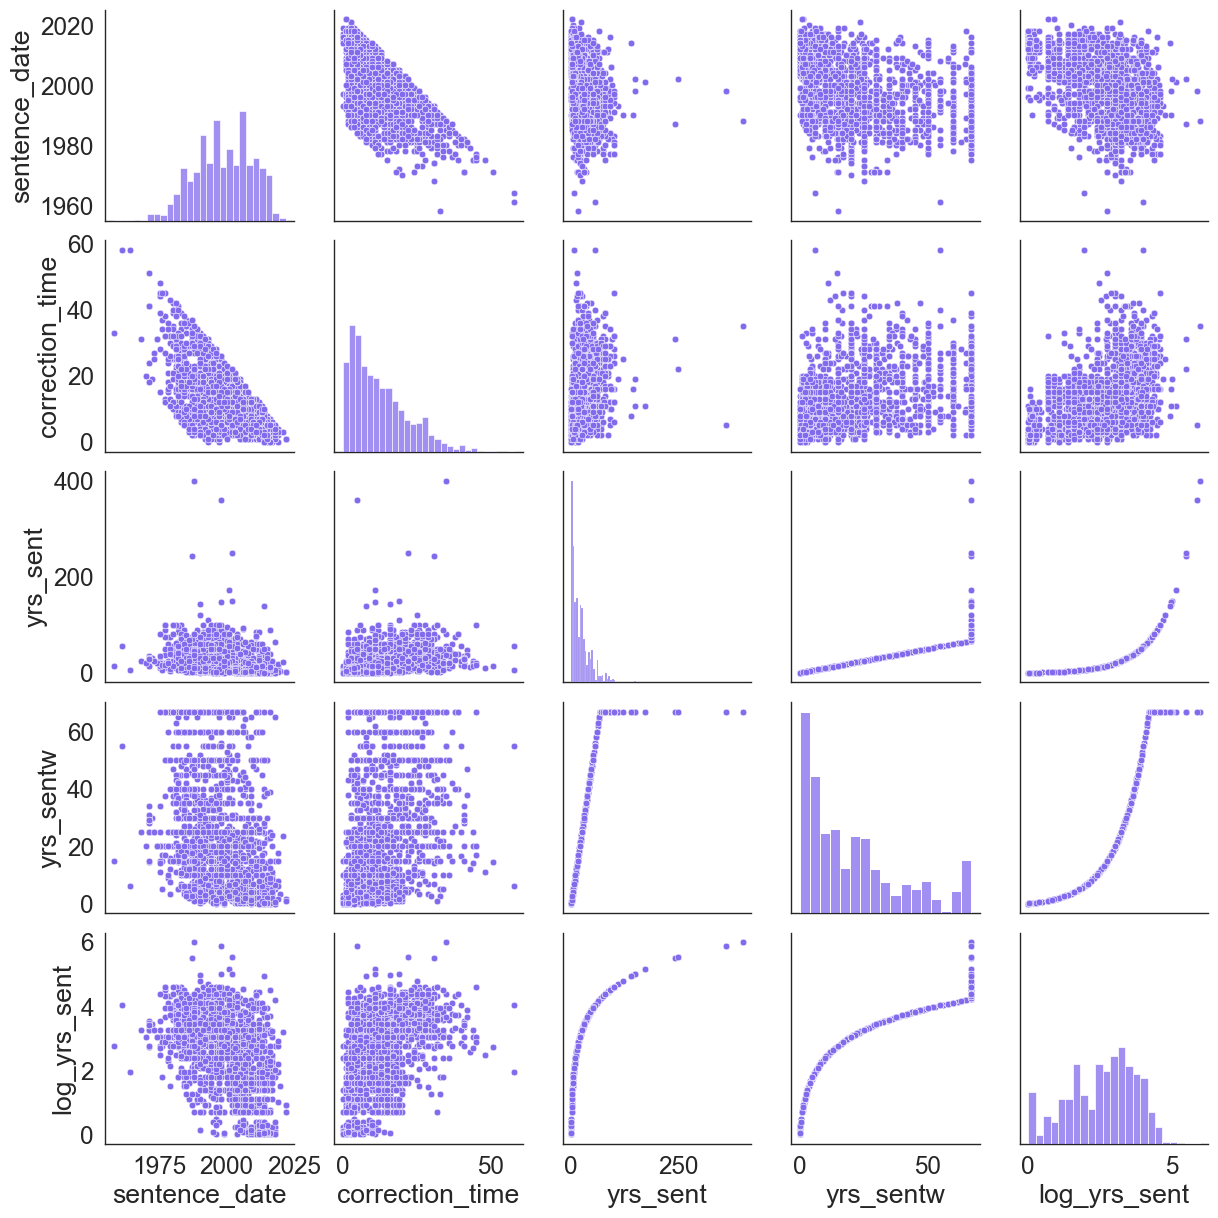

In [8]:
vars = ['sentence_date', 'correction_time', 'yrs_sent', 'yrs_sentw', 'log_yrs_sent']
sns.pairplot(df[vars])

Text(0, 0.5, 'Correction Time\n(Years)')

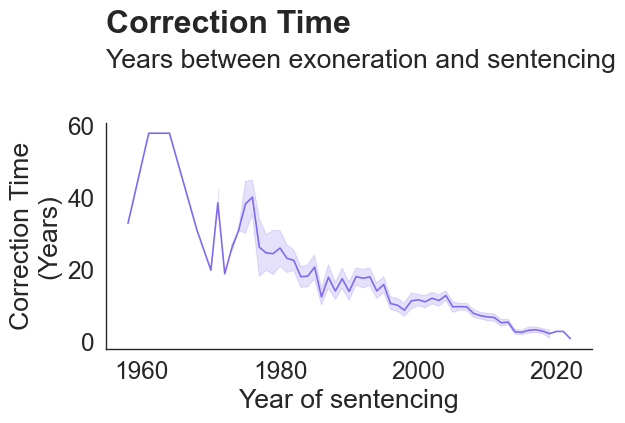

In [9]:
sns.lineplot(data=df, x='sentence_date', y='correction_time')
plt.suptitle("Correction Time", x=0.387, fontweight='bold', y=0.9)
plt.title("Years between exoneration and sentencing", fontweight='regular')
plt.xlabel("Year of sentencing")
plt.ylabel("Correction Time\n(Years)")

## Plot by decade

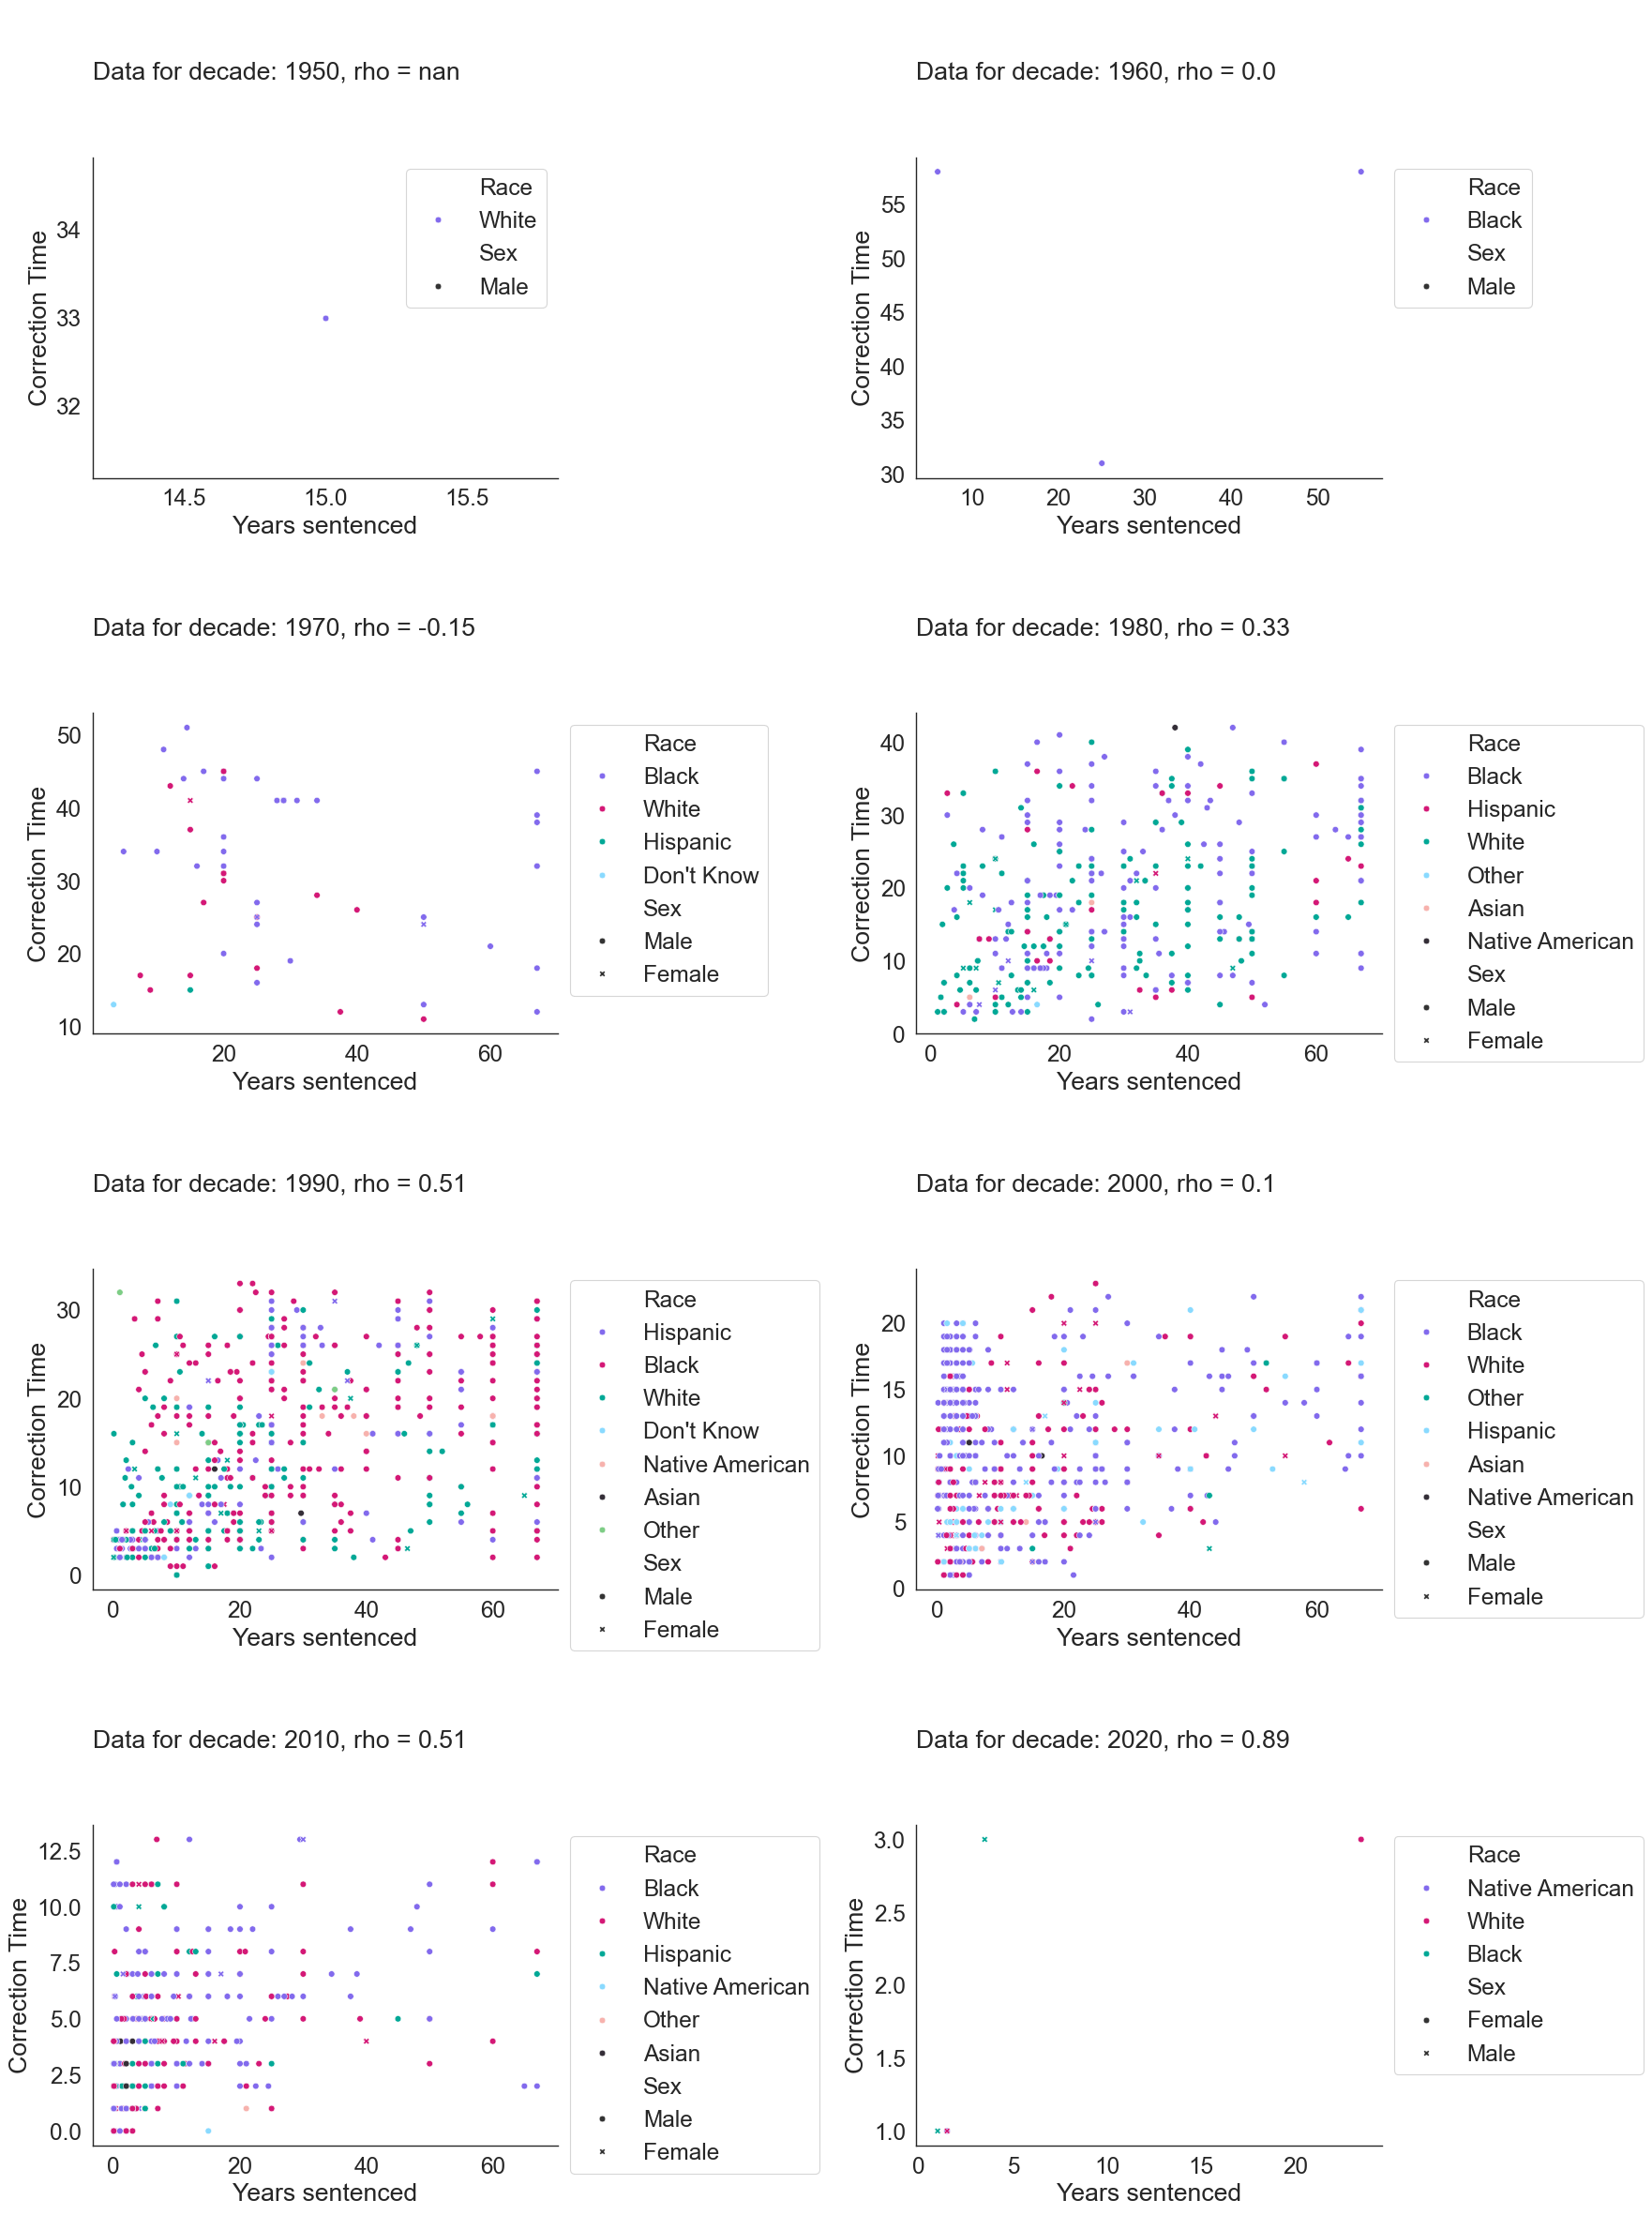

In [10]:
sent_var = 'yrs_sentw'
decades = sorted(df['sentence_decade'].unique())
fig, axs = plt.subplots(nrows=int(np.ceil(len(decades) / 2)), ncols=2, figsize=(18, 6 * int(np.ceil(len(decades) / 2))))
axs = axs.flatten()

for i, decade in enumerate(decades):
    tdf = df[df['sentence_decade'] == decade]
    corr = np.round(tdf[[sent_var, 'correction_time']].corr('spearman').reset_index()['yrs_sentw'].iloc[1], 2)
    
    sns.scatterplot(ax=axs[i], data=tdf, x=sent_var, y='correction_time', hue='Race', style='Sex')
    axs[i].set_title(f"\n\nData for decade: {decade}, rho = {corr}\n")
    axs[i].set_xlabel("Years sentenced")
    axs[i].set_ylabel("Correction Time")
    axs[i].legend(bbox_to_anchor=[1, 1])

plt.tight_layout()
plt.show()

## Overall Correlation

### Compute  zero orderbootstrap correlations

In [11]:
corr_data = bootstrap_cor(df['yrs_sentw'], df['correction_time'], "spearman")
print(corr_data)

{'obs': 0.4851537553280034, 'lower': 0.4491731866175354, 'upper': 0.5183897397317452, 'sig': 1, 'round2_obs': 0.49, 'round2_lower': 0.45, 'round2_upper': 0.52}


### Plots

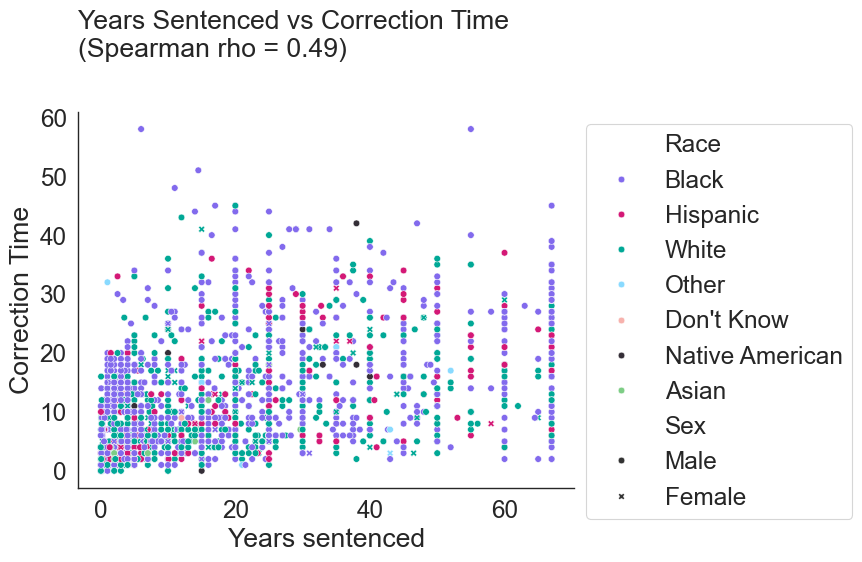

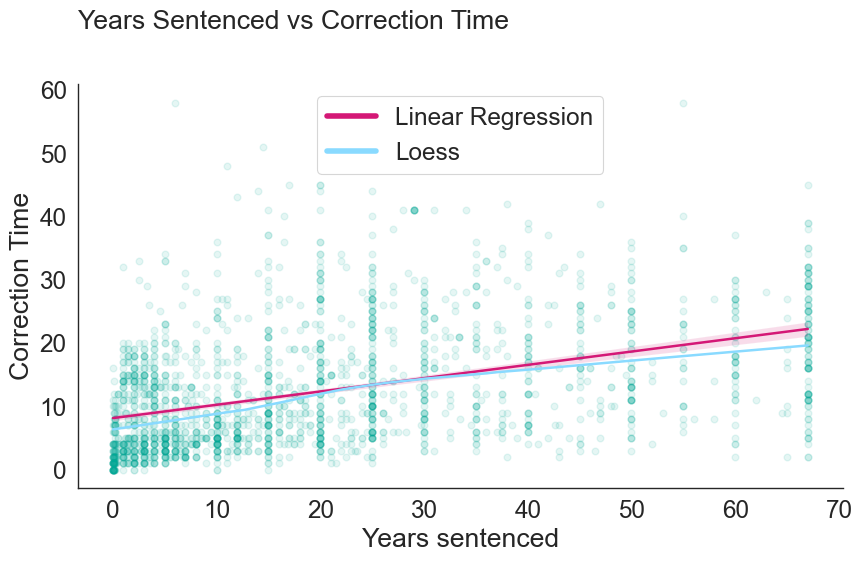

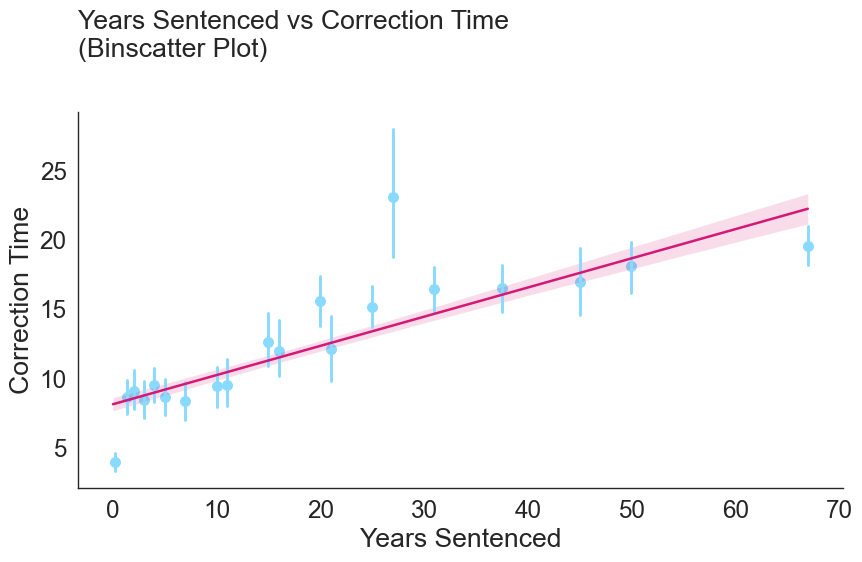

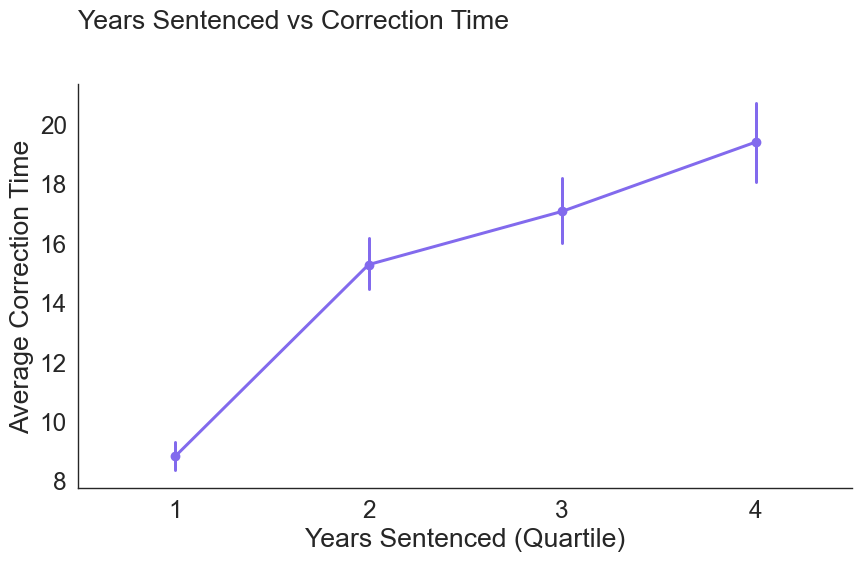

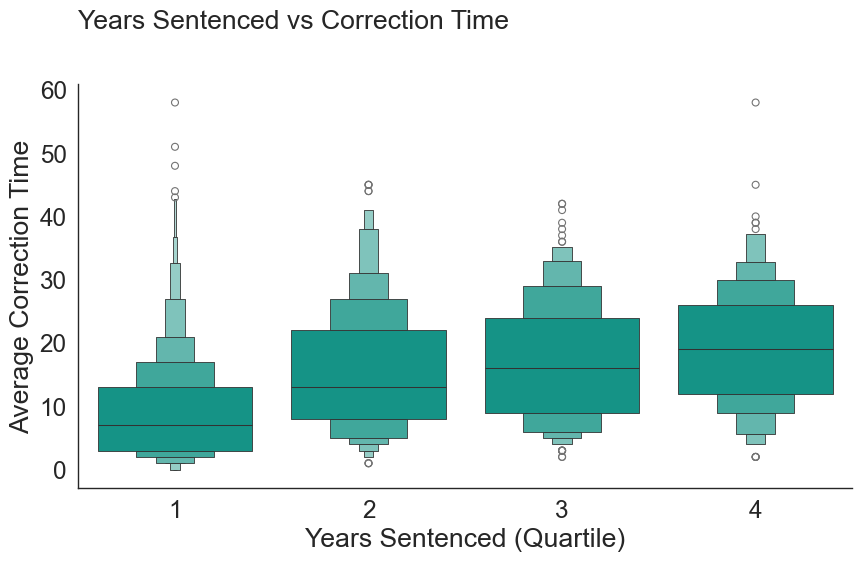

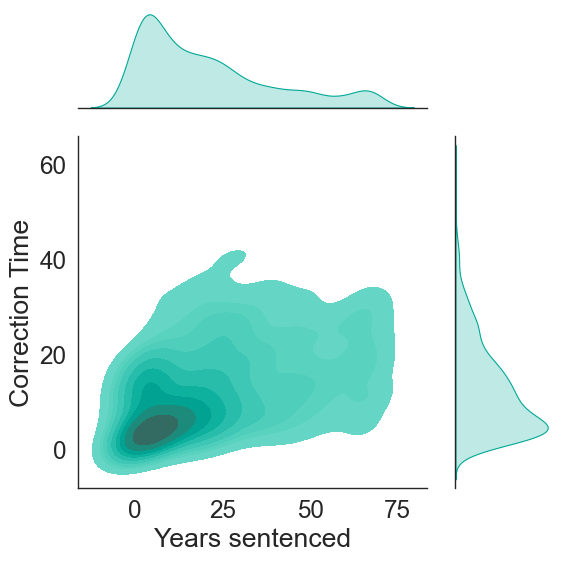

In [12]:
#################
# SCATTER
#################
plt.figure(figsize=(9,6))
corr = np.round(corr_data['obs'],2)
sns.scatterplot(data=df, x='yrs_sentw', y='correction_time', hue='Race', style='Sex')
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Years sentenced")
plt.ylabel("Correction Time")
plt.title(f"Years Sentenced vs Correction Time\n(Spearman rho = {corr:.2f})")
plt.show()


#################
# LINE PLOT
#################
plt.figure(figsize=(9, 6))
sns.regplot(data=df, x='yrs_sentw', y='correction_time', scatter_kws={'alpha': 0.1}, line_kws={'color': mypal[1]}, color=mypal[2])
sns.regplot(data=df, x='yrs_sentw', y='correction_time', scatter=False, lowess=True, line_kws={'color': mypal[3]})
plt.xlabel("Years sentenced")
plt.ylabel("Correction Time")
plt.title("Years Sentenced vs Correction Time")

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], color=mypal[1], lw=4, label='Linear Regression'),
    plt.Line2D([0], [0], color=mypal[3], lw=4, label='Loess')
]
plt.legend(handles=legend_elements)
plt.savefig("exon_lineplot.png", dpi=400, transparent=False)

plt.show()


#################
# BINSCATTER
#################
plt.figure(figsize=(9, 6))
sns.regplot(data=df, x='yrs_sentw', y='correction_time', x_bins=20,
            line_kws={'color': mypal[1]},
            scatter_kws={'color': mypal[3]})  
plt.xlabel("Years Sentenced")
plt.ylabel("Correction Time")
plt.title("Years Sentenced vs Correction Time\n(Binscatter Plot)")
plt.savefig("exon_binscatter.png", dpi=400, transparent=False)
plt.show()



#################
# BINNED 
#################
df['yrs_sentw_bin'] = pd.cut(df['yrs_sentw'], bins=4, labels=False)+1  
plt.figure(figsize=(9, 6))
sns.pointplot(data=df, x='yrs_sentw_bin', y='correction_time')
plt.xlabel("Years Sentenced (Quartile)")
plt.ylabel("Average Correction Time")
plt.title("Years Sentenced vs Correction Time")
plt.tight_layout()  
plt.savefig("exon_binned.png", dpi=400, transparent=False)
plt.show()

#################
# BINNED BOXEN
#################
df['yrs_sentw_bin'] = pd.cut(df['yrs_sentw'], bins=4, labels=False)+1  
plt.figure(figsize=(9, 6))
sns.boxenplot(data=df, x='yrs_sentw_bin', y='correction_time', color=mypal[2])
plt.xlabel("Years Sentenced (Quartile)")
plt.ylabel("Average Correction Time")
plt.title("Years Sentenced vs Correction Time")
plt.tight_layout()  
plt.savefig("exon_boxen_binned.png", dpi=400, transparent=False)
plt.show()


#################
# KDE 
#################
sns.jointplot(data=df, x='yrs_sentw', y='correction_time', kind='kde', color=mypal[2], fill=True, height=6, ratio=3)

plt.xlabel("Years sentenced")
plt.ylabel("Correction Time")
plt.title("")  
plt.tight_layout()  
plt.savefig("exon_kde.png", dpi=400, transparent=False)

plt.show()

## BinThresh Method

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_27403/2378560338.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thresh{yr}", palette=mypal)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_27403/2378560338.py:28: UserWarning: The palette list has more values (15) than needed (4), which may not be intended.
  sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thresh{yr}", palette=mypal)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_27403/2378560338.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thr

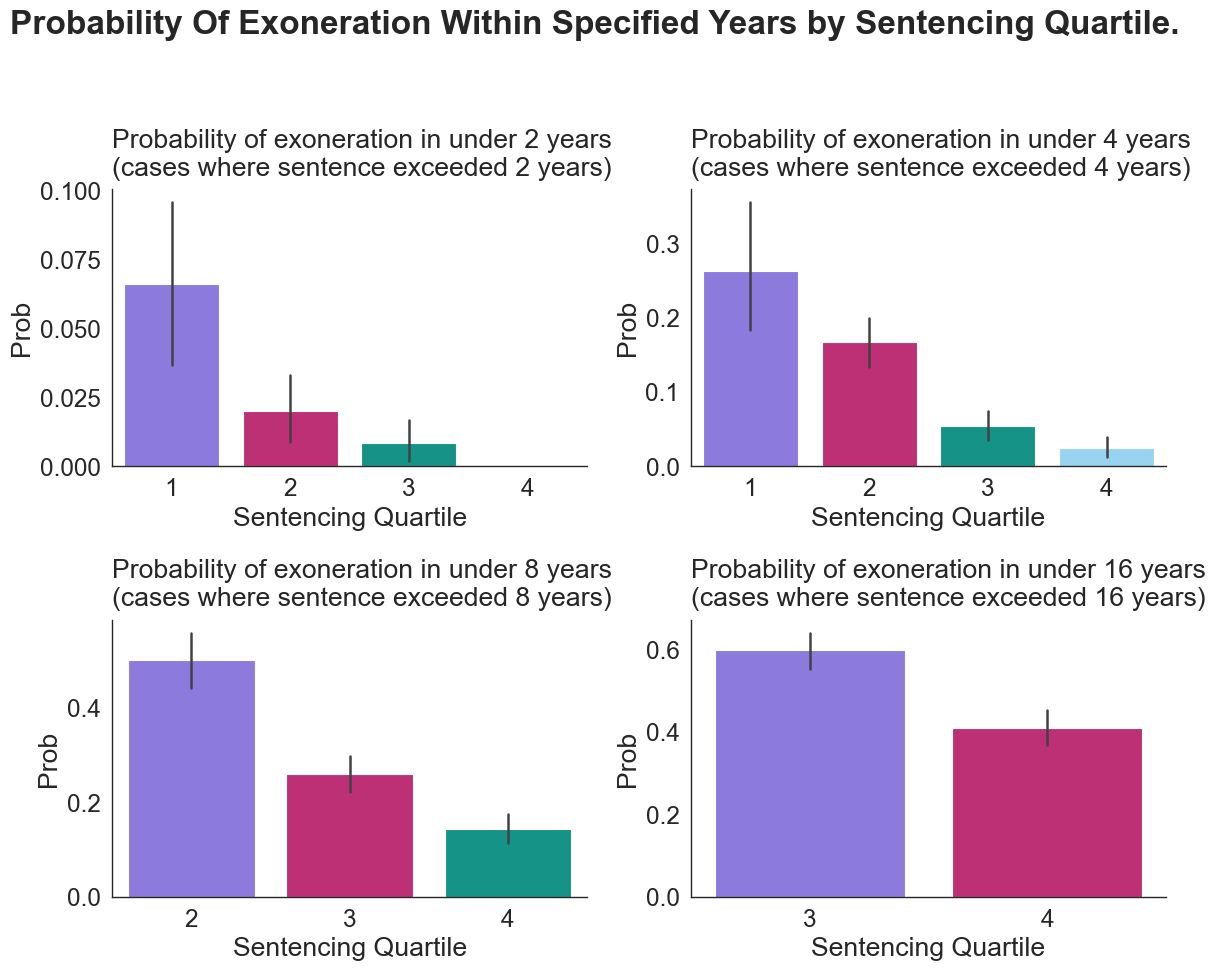

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
def bin_thresh(x, yr_thresh):
    yrs_sent = x['yrs_sent']
    cor_time = x['correction_time']
    if yrs_sent <= yr_thresh:
        return np.NaN 
    else:
        if cor_time < yr_thresh:
            return 1
        else:
            return 0


df['yrs_sentw_bin'] = pd.qcut(df['yrs_sentw'], 4, labels=False) + 1

plt.figure(figsize=(12, 10))

main_title = "Probability Of Exoneration Within Specified Years by Sentencing Quartile."
plt.suptitle(main_title, fontsize=24, fontweight='bold')

for i, yr in enumerate([2, 4, 8, 16], 1):
    df[f"thresh{yr}"] = df.apply(lambda x: bin_thresh(x, yr), axis=1)
    
    plt.subplot(2, 2, i)
    sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thresh{yr}", palette=mypal)
    plt.xlabel("Sentencing Quartile")
    plt.ylabel("Prob")
    plt.title(f"Probability of exoneration in under {yr} years\n(cases where sentence exceeded {yr} years)", pad=10)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("exon_thresh.png", dpi=400, transparent=False)
plt.show()


## Fourth quartile sentencing: Prob exonerated under 2 years?

In [14]:
df.groupby(by=['yrs_sentw_bin'])['thresh2'].value_counts(normalize=True)

yrs_sentw_bin  thresh2
1              0.0        0.933824
               1.0        0.066176
2              0.0        0.980132
               1.0        0.019868
3              0.0        0.991632
               1.0        0.008368
4              0.0        1.000000
Name: proportion, dtype: float64

# OLS

In [15]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='correction_time ~ C(sentence_date) + dna + yrs_sentw + Age + C(Sex) + C(Race) + C(worst_crime) + C(County)', data=df).fit()

display(mod.summary())

PatsyError: Error evaluating factor: NameError: name 'dna' is not defined
    correction_time ~ C(sentence_date) + dna + yrs_sentw + Age + C(Sex) + C(Race) + C(worst_crime) + C(County)
                                         ^^^

In [ ]:
mod.params

In [ ]:
def clean_statsmodels_name(var_name):
    """
    If a name is like C(Race)[T.Other] then it returns Race==Other, 
    else returns normal name. 

    """
    # regex expression to match the pattern 'C(Race)[T.Other]'
    pattern = r'C\((.*?)\)\[T\.(.*?)\]'
    match = re.match(pattern, var_name)

    if match:
        factor, value = match.groups()
        cleaned_name = f"{factor}=='{value}'"
    else:
        # If the pattern does not match, return the original variable name
        cleaned_name = var_name

    return cleaned_name

def filter_vars(all_vars, sub_str):
    matched_vars = set()
    for var in all_vars:
        if any(sub in var for sub in sub_str):
            matched_vars.add(var)

    return list(matched_vars)


sum_res = pd.read_html(mod.summary().tables[1].as_html(),header=0,index_col=0)[0].reset_index()
sum_res = sum_res.rename(columns={'index':'var'})
interesting_vars = ["C(Race)", "C(Sex)", "yrs_sentw",'C(worst_crime)']
my_vars = filter_vars(sum_res['var'].tolist(), interesting_vars)

#################
# Plot of reg coefs
#################
make_aesthetic(with_gridlines=True)

df_sub = sum_res.query("var in @my_vars").sort_values(by=['coef'], ascending=False)

df_sub['clean_var'] = df_sub['var'].apply(clean_statsmodels_name)
df_sub['error_lower'] = df_sub['coef'] - df_sub['[0.025']
df_sub['error_upper'] = df_sub['0.975]'] - df_sub['coef']
errors = df_sub[['error_lower', 'error_upper']].T.values
df_sub['color'] = df_sub.apply(lambda row: mypal[3] if (row['P>|t|'] < 0.05 and row['coef'] > 0) else (mypal[1] if (row['P>|t|'] < 0.05 and row['coef'] < 0) else 'gray'), axis=1)

plt.figure(figsize=(12,18))
for index, row in df_sub.iterrows():
    plt.errorbar(row['coef'], row['clean_var'], xerr=[[row['error_lower']], [row['error_upper']]], fmt='o', capsize=5, color=row['color'])
sns.pointplot(y='clean_var', x='coef', data=df_sub, capsize=0.1, join=False, palette=df_sub['color'].tolist())
plt.suptitle("Predictors of Correction Time", fontweight='bold', x=0.435)
plt.title("Correction time is the years between exoneration and sentencing.\nDisplaying point estimate and 95% CIs. Gray indicates p>0.05.", fontweight='regular', x=-0.4)
plt.ylabel("")
plt.xlabel("Effect (in years)")
plt.axvline(x=0, color='gray', linestyle='dashed')

################################
# print coef clean to copy paste
################################
beta = np.round(mod.params['yrs_sentw'], 2)
se = np.round(mod.bse['yrs_sentw'], 2)
ci_low = np.round(mod.conf_int().loc['yrs_sentw', 0], 2)
ci_high = np.round(mod.conf_int().loc['yrs_sentw', 1], 2)
f = f"Beta = {beta} [SE = {se}, 95% CI = ({ci_low}, {ci_high})]"
print("Reg results for yrs_sent coef:", f)

#################
# Actual vs predicted
#################

plt.figure(figsize=(10, 6))
df['preds'] = mod.predict(df).values
sns.scatterplot(data=df, y='preds', x='correction_time', color=mypal[3])
sns.regplot(data=df, y='preds', x='correction_time', scatter=False, color=mypal[1], ci=False)
plt.title("Exoneration Time Predictions Against Actual Data")
plt.xlabel("Actual Correction Time")
plt.ylabel("Predicted Correction Time")


# Life years saved

## Calculcations

In [ ]:
def assign_correction_time(df2, x):
    # Correction time is more conservative for the simulation. 
    yrs_sent_rank = x['yrs_sent_rank']
    paired_correction_time = df2[df2['time_served_rank'] == yrs_sent_rank]['correction_time'].iloc[0]
    return min(x['yrs_sent'], paired_correction_time)

df2 = df.copy()
df2 = df2.sample(frac=1, random_state=42)
df2['time_served'] = np.minimum(df2['correction_time'], df2['yrs_sent'])
df2['yrs_sent_rank'] = df2['yrs_sent'].rank(ascending=False, method='first')
df2['time_served_rank'] = df2['time_served'].rank(ascending=True, method='first')
df2['opt_time_served'] = df2.apply(lambda x: assign_correction_time(df2, x), axis=1)

## Summary stats

In [ ]:
opt_time = df2['opt_time_served'].sum()
act_time = df2['time_served'].sum()
reduc_int = opt_time - act_time
reduc_per = (reduc_int/act_time)*100

print(f"Actual time served: {int(np.round(act_time,0))}, Opt time served: {int(np.round(opt_time,0))}, Diff {int(np.round(reduc_int,0))}, Per {int(np.round(reduc_per,0))}")

## Plot

In [ ]:
make_aesthetic()
original_time_served_sum = df2['time_served'].sum()
opt_time_served_sum = df2['opt_time_served'].sum()

data_for_plot = {
    'Correction Time Type': ['Actual Data', 'Counterfactual: Longest Sentence\nCorrected First'],
    'Total Correction Time': [original_time_served_sum, opt_time_served_sum]
}

df_plot = pd.DataFrame(data_for_plot)

colors = [matplotlib.colors.to_rgb(mypal[0]), matplotlib.colors.to_rgb(mypal[1])]

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Correction Time Type', y='Total Correction Time', data=df_plot, palette=mypal[2:4])

for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), ',.0f'),  
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom', xytext=(0, 8),
                     textcoords='offset points')

# Set the title and labels
plt.suptitle("Reducing Wrongful Imprisonment By Exoneration Prioritization", fontweight='bold', x=0.59)
plt.title(label="For each individual, the number of 'wrongful imprisonment years' is the time served \nbetween sentencing and exoneration. Here we simulate how many total\nwrongful imprisonment years would be averted if sentences were exonerated\nin order of length, such that the longest sentence was exonerated first.", size=15) 
plt.ylabel('Total Wrongful\nImprisonment Years')
plt.xlabel("")

# Show the plot
plt.tight_layout()  
plt.savefig("exon_simple_counter.png", dpi=400, transparent=False)
plt.show()


## More nuanced counterfactual

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


##########################
# FUNCTION
##########################
def simulate_correction_time(df, group_column):
    df = df.copy()
    if group_column == 'unconstrained':
        df['yrs_sent_rank'] = df['yrs_sent'].rank(ascending=False, method='first')
        df['time_served_rank'] = df['time_served'].rank(ascending=True, method='first')
        df['unconstrained_opt_time_served'] = df.apply(
            lambda x: min(x['yrs_sent'], df[df['time_served_rank'] == x['yrs_sent_rank']]['correction_time'].iloc[0]),
            axis=1
        )
    else:
        df['shuffled_correction_time'] = df.groupby(group_column)['correction_time'].transform(lambda x: x.sample(frac=1, random_state=42).values)
        df['yrs_sent_rank'] = df.groupby(group_column)['yrs_sent'].rank(ascending=False, method='first')
        df['shuffled_time_rank'] = df.groupby(group_column)['shuffled_correction_time'].rank(ascending=True, method='first')

        rank_to_time = df.groupby(group_column).apply(
            lambda g: pd.Series(g['shuffled_correction_time'].values, index=g['shuffled_time_rank'])
        ).reset_index().rename(columns={0: 'mapped_correction_time'})

        df = df.merge(rank_to_time, how='left', on=[group_column, 'shuffled_time_rank'])

        opt_time_served_col = f'{group_column}_opt_time_served'
        df[opt_time_served_col] = np.minimum(df['yrs_sent'], df['mapped_correction_time'])

    return df


make_aesthetic()

##########################
# COMPUTE COUNTERFACTUALS
##########################
GROUP_VARS = ['unconstrained', 'State', 'worst_crime']
original_time_served_sum = df2['time_served'].sum()
data_for_plot = {'Correction Time Type': ['Actual\nData'], 'Total Correction Time': [original_time_served_sum]}
df3 = df.copy()
df3 = df3.sample(frac=1, random_state=42)
df3['time_served'] = np.minimum(df3['correction_time'], df3['yrs_sent'])

for group_var in GROUP_VARS:
    simulated_df = simulate_correction_time(df3, group_var)
    opt_time_served_col = f'{group_var}_opt_time_served' if group_var != 'unconstrained' else 'unconstrained_opt_time_served'
    total_opt_time_served = simulated_df[opt_time_served_col].sum()
    if group_var == "unconstrained":
        name = "Long Sentence\nCorrected First:\nUnconstrained"
    else:
        name = f'Long Sentence\nCorrected First:\nConstraint = {group_var.replace("_", " ").title()}'
    data_for_plot['Correction Time Type'].append(name)
    data_for_plot['Total Correction Time'].append(total_opt_time_served)



##########################
# PLOT
##########################
df_plot = pd.DataFrame(data_for_plot)
df_plot = df_plot.sort_values('Total Correction Time', ascending=False)

# Plotting
plt.figure(figsize=(13, 8))
barplot = sns.barplot(x='Correction Time Type', y='Total Correction Time', data=df_plot, palette='Purples_r')
for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), ',.0f'),  
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom', xytext=(0, 8),
                     textcoords='offset points')

plt.suptitle("Reducing Wrongful Imprisonment By Exoneration Prioritization", fontweight='bold', x=0.5)
plt.title(label="For each individual, the number of 'wrongful imprisonment years' is the time served between sentencing\nand exoneration. Here we simulate how many total wrongful imprisonment years would be averted if\nsentences were exonerated in order of length, such that the longest sentence was exonerated first.\n\nDifferent scenarios have different constraints,where times are shuffled within blocks.", size=15) 

plt.ylabel('Total Wrongful\nImprisonment Years')
plt.xlabel("")
plt.xticks(rotation=0)


plt.tight_layout()  
plt.savefig("exon_complex_counter.png", dpi=400, transparent=False)
plt.show()



# Exoneration after sentence

In [ ]:
print("What percent of people exonerated after sentence?")
print(np.round(np.mean(df['correction_time'].values > df['yrs_sent']),2)*100)

# Related case cluster

In [ ]:
df.query("yrs_sentw >= 20 & yrs_sentw <= 30 & correction_time >= 35 & correction_time <= 42")[['State', 'County', 'Last Name', 'First Name', 'Sentence', 'Date of Crime Year', 'Exonerated', 'yrs_sentw', 'correction_time']]

In [ ]:
df['DNA']

In [ ]:
df['FC']

In [ ]:
df['dna'] = df['DNA'].apply(lambda x: 1 if x=="DNA" else 0)
df['dna'] = df['DNA'].apply(lambda x: 1 if x=="DNA" else 0)

In [ ]:
df.columns